# Computer Assignment 5 Phase 2
## TensorFlow - Keras
### Ali Bahari
### Project Name: Computer Assignment 5 Phase 2 TensorFlow - Keras

Project Goal: Create a neural network to determine the race of the people in the given images using Keras.

In this assignment we'll use UTKFace dataset which is images of people with their age, gender, race and time included. For our purposes we'll only use people's race. After extracting people's race, creating the whole dataset and splitting it into train and test sets, we'll create our neural network. After creating, compiling and training our network(model) we'll tune some of the hyperparameters in the network to get the best results and finally we'll analyze every aspect of our network(model).

In [29]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!cp "/content/drive/MyDrive/UTKFace.tar.gz" .

In [31]:
!tar xvzf UTKFace.tar.gz

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [32]:
from tensorflow.keras import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import tensorboard
import os
from sklearn.utils import shuffle
from keras import backend as K

In [33]:
!ls /content

drive  sample_data  UTKFace  UTKFace.tar.gz


In [34]:
imagesFolderPath = "/content/UTKFace"
imagesPath = []; races = []

for image in os.listdir(imagesFolderPath):
  imageNameParts = image.split(".")

  if(len(imageNameParts[0].split("_")) == 4):
    imagesPath.append(os.path.join(imagesFolderPath , image))
    _ , _ , race , _ = imageNameParts[0].split("_")
    races.append(int(race))
  else:
    continue

In [35]:
class_labels = {0: "White" , 1: "Black" , 2: "Asian" , 3: "Indian" , 4: "Others"}
races = [str(to_categorical(race , len(class_labels))) for race in races]

dataFrame = pd.DataFrame({
    "image": imagesPath,
    "race": races
})

In machine learning we want numerical values but most of the time there will be categorical values in our dataset. We can convert these values to numerical values. We can deal with categorical values in two different ways. The first one is using label encoding, which assigns one number to each category which here in our dataset for race this method is used in the image names. The second one, that we're using for creating our dataframe, is using one-hot encoding, which will assign different columns to each category. Before we start transforming our data, it is important to figure out if the feature we are working on is ordinal or nominal. An ordinal feature is best described as a feature with natural, ordered categories and the distances between the categories are unknown. We can use LabelEncoder for ordinal features not nominal features. In nominal features we can’t replace the categories by a number since this would imply the features have an order, which is wrong for race in our dataset. So we should use a nominal encoding. The most popular way to encode nominal features is one-hot-encoding. Essentially, each categorical feature with n categories is transformed into n binary features. If the number of the categorical features is low (relative to the amount of data) one-hot encoding will work best. But if the number of the categorical features is large and the dataset is small, one-hot encoding may not be feasible, and regressor may not be able to efficiently learn.

So here since we only have 5 classes in a huge dataframe, race is a nominal feature and also since one hot encoding values are 0 or 1 it can't get biased like in label encoding when the number of unique values are a lot. One hot is kinda normalized and the range of its values is much less, all the values will be multiplied by either 1 or 0 so this will prevent being biased despite label encoding which can multiply values by higher numbers and cause being biased towards values which are multiplied by higher numbers.

In [36]:
dataFrame.head()

image              race
0  /content/UTKFace/85_1_0_20170110183802977.jpg....  [1. 0. 0. 0. 0.]
1  /content/UTKFace/26_0_1_20170113151548832.jpg....  [0. 1. 0. 0. 0.]
2  /content/UTKFace/26_0_0_20170104170627658.jpg....  [1. 0. 0. 0. 0.]
3  /content/UTKFace/65_1_0_20170110131349129.jpg....  [1. 0. 0. 0. 0.]
4  /content/UTKFace/26_1_1_20170116233613793.jpg....  [0. 1. 0. 0. 0.]

In [37]:
print(dataFrame.nunique())

image    23705
race         5
dtype: int64


In [38]:
dataFrame["race"].value_counts()

[1. 0. 0. 0. 0.]    10078
[0. 1. 0. 0. 0.]     4526
[0. 0. 0. 1. 0.]     3975
[0. 0. 1. 0. 0.]     3434
[0. 0. 0. 0. 1.]     1692
Name: race, dtype: int64

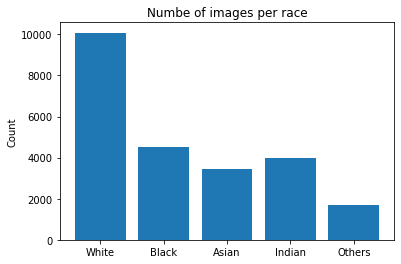

In [39]:
classNames = {"[1. 0. 0. 0. 0.]": "White" , "[0. 1. 0. 0. 0.]": "Black" , "[0. 0. 1. 0. 0.]": "Asian" , "[0. 0. 0. 1. 0.]": "Indian" , "[0. 0. 0. 0. 1.]": "Others"}
races = {"White": -1 , "Black": -1 , "Asian": -1 , "Indian": -1 , "Others": -1}
for race , counts in dataFrame["race"].value_counts().items():
  races[classNames[race]] = counts

plt.bar(*zip(*races.items()))
plt.ylabel("Count")
plt.title("Numbe of images per race")
plt.show()

In [85]:
print(races)

{'White': 10078, 'Black': 4526, 'Asian': 3434, 'Indian': 3975, 'Others': 1692}


=============== White ===============



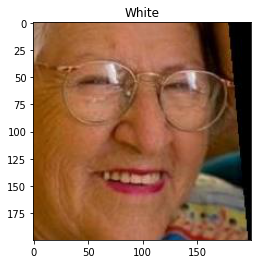



=============== Black ===============



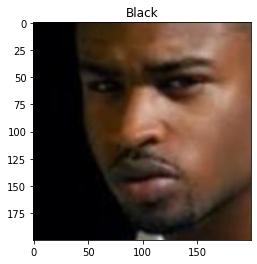



=============== Asian ===============



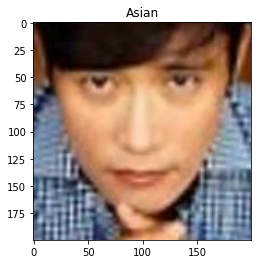



=============== Indian ===============



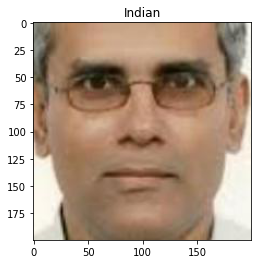



=============== Others ===============



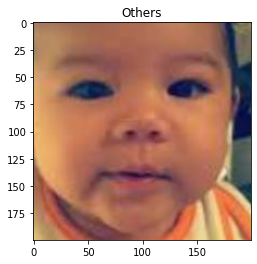

In [40]:
classNamesOneHotEncoded = ["[1. 0. 0. 0. 0.]" , "[0. 1. 0. 0. 0.]" , "[0. 0. 1. 0. 0.]" , "[0. 0. 0. 1. 0.]" , "[0. 0. 0. 0. 1.]"]

for classNameOneHotEncoded in classNamesOneHotEncoded:
  targetImagePath , targetRaceEncoded = dataFrame[dataFrame["race"] == classNameOneHotEncoded].iloc[0]
  targetImage = plt.imread(targetImagePath)

  print("=============== " + classNames[targetRaceEncoded] + " ===============\n")
  
  plt.figure()
  plt.imshow(targetImage)
  plt.title(classNames[targetRaceEncoded])
  plt.show()
  print("\n")

In [41]:
dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1./255 ,
    validation_split = 0.3
)

In [42]:
trainDataset = dataGenerator.flow_from_dataframe(
    dataframe = dataFrame,
    x_col = "image",
    y_col = "race",
    target_size = (100 , 100),
    color_mode = "grayscale",
    batch_size = 32,
    subset = "training",
    class_mode = "categorical",
    shuffle = False
)

Found 16594 validated image filenames belonging to 5 classes.


In [43]:
testDataset = dataGenerator.flow_from_dataframe(
    dataframe = dataFrame,
    x_col = "image",
    y_col = "race",
    target_size = (100 , 100),
    color_mode = "grayscale",
    batch_size = 32,
    subset = "validation",
    class_mode = "categorical",
    shuffle = False
)

Found 7111 validated image filenames belonging to 5 classes.


In [44]:
print("Total: ")
print(dataFrame.nunique())
print("\nTrain: " + str(trainDataset.n) + " images | " + str(len(trainDataset.class_indices)) + " classes")
print("Test: " + str(testDataset.n) + " images | " + str(len(testDataset.class_indices)) + " classes")

Total: 
image    23705
race         5
dtype: int64

Train: 16594 images | 5 classes
Test: 7111 images | 5 classes


In [45]:
input = layers.Input(shape = (100 , 100 , 1))

output = layers.Flatten()(input)
output = layers.Dense(2048 , activation = "relu")(output)
output = layers.Dense(1024 , activation = "relu")(output)
output = layers.Dense(5 , activation = "softmax")(output)

In [46]:
# Add K.epsilon() to prevent division by 0
def recallMetric(actual, pred):
    truePositives = K.sum(K.round(K.clip(actual * pred , 0 , 1)))
    actualPositives = K.sum(K.round(K.clip(actual, 0, 1)))
    return truePositives / (actualPositives + K.epsilon())

def precisionMetric(actual, pred):
    truePositives = K.sum(K.round(K.clip(actual * pred, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(pred, 0, 1)))
    return truePositives / (predictedPositives + K.epsilon())

def f1Metric(actual, pred):
    precision = precisionMetric(actual, pred)
    recall = recallMetric(actual, pred)
    return 2 * ( (precision * recall) / (precision + recall + K.epsilon()) )

The functions above were implemeted for training the network with these metrics so that we would have recall, precision and f1 after each epoch and since this wasn't mandatory I only used them for the first training.

In [47]:
network = models.Model(inputs = input , outputs = output)
network.compile(
    optimizer = optimizers.SGD(learning_rate = 0.01),
    loss = "categorical_crossentropy",
    metrics = ["accuracy" , recallMetric , precisionMetric , f1Metric]
)

In [48]:
network.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              20482048  
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 5125      
Total params: 22,585,349
Trainable params: 22,585,349
Non-trainable params: 0
_________________________________________________________________


.summary() is used to show each layers parameters. summary() will show useful information such as layers and their order in the model, output shape of each layer , number of parameters(weights) in each layer and total number of parameters(weights) in the model.

For the network above first we have flatten the input, so (100, 100) will become (1, 10000) which we will show as 10000, then we have 2048 neurons in the first layer. So we had 10000 neurons in the previous layer and 2048 in this layer. Also we have a bias vector with size of number of the neurons in this layer. Finally putting all of this together we will have the following number of parameters for this layer:

$ 10000 * 2048 + 2048 = 10001 * 2048 = 20482048 $

The number above is equal to the number given by .summary().

The calculations for the next layer is exactly the same except the layers will change. 10000 will change to 2048 and 2048 will change to 1024 also in the new layer the bias size will be 1024 so we'll have the following number of parameters for the second hidden layer:

$ 2048 * 1024 + 1024 = 2049 * 1024 = 2098176 $

Like before the number above is equal to the corresponding number given by .summary().

For the ouput layer the calculations is exactly the same as before but some number's will change as following:

$ 1024 * 5 + 5 = 1025 * 5 = 5125 $

Like before the number above is equal to the corresponding number given by .summary().

All the parameters are calculated so in total we'll have:

$ 20482048 + 2098176 + 5125 = 22585349 $

Also the same as .summary().

In [49]:
history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

Epoch 1/10
519/519 [==============================] - 23s 42ms/step - loss: 1.2807 - accuracy: 0.5075 - recallMetric: 0.2815 - precisionMetric: 0.6437 - f1Metric: 0.3713 - val_loss: 1.1623 - val_accuracy: 0.5378 - val_recallMetric: 0.4439 - val_precisionMetric: 0.5981 - val_f1Metric: 0.5081
Epoch 2/10
519/519 [==============================] - 21s 41ms/step - loss: 1.0986 - accuracy: 0.5839 - recallMetric: 0.4203 - precisionMetric: 0.7004 - f1Metric: 0.5189 - val_loss: 1.1522 - val_accuracy: 0.5434 - val_recallMetric: 0.4130 - val_precisionMetric: 0.6421 - val_f1Metric: 0.5007
Epoch 3/10
519/519 [==============================] - 21s 41ms/step - loss: 1.0092 - accuracy: 0.6330 - recallMetric: 0.4903 - precisionMetric: 0.7324 - f1Metric: 0.5834 - val_loss: 0.9680 - val_accuracy: 0.6491 - val_recallMetric: 0.4793 - val_precisionMetric: 0.7776 - val_f1Metric: 0.5901
Epoch 4/10
519/519 [==============================] - 21s 41ms/step - loss: 0.9658 - accuracy: 0.6496 - recallMetric: 0.5219

Train:
              precision    recall  f1-score   support

       White       0.05      0.63      0.09        87
       Black       0.83      0.50      0.62      4487
       Asian       0.71      0.76      0.74      2252
      Indian       0.70      0.90      0.79      2475
      Others       0.80      0.78      0.79      7293

    accuracy                           0.72     16594
   macro avg       0.62      0.72      0.61     16594
weighted avg       0.78      0.72      0.73     16594

Test:
              precision    recall  f1-score   support

       White       0.03      0.58      0.07        31
       Black       0.79      0.50      0.61      2001
       Asian       0.68      0.74      0.70       960
      Indian       0.65      0.86      0.74      1003
      Others       0.79      0.75      0.77      3116

    accuracy                           0.69      7111
   macro avg       0.59      0.69      0.58      7111
weighted avg       0.75      0.69      0.71      7111



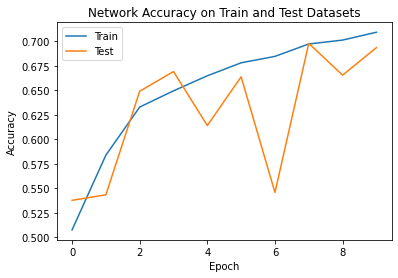

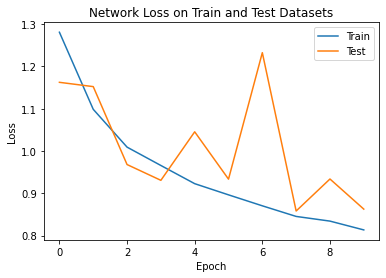

In [50]:
trainPred = network.predict(trainDataset , batch_size = 32)
testPred = network.predict(testDataset , batch_size = 32)

print("Train:")
print(classification_report(np.argmax(np.array(trainPred), axis = 1), np.array(trainDataset.classes), target_names=["White" , "Black" , "Asian" , "Indian" , "Others"]))
print("Test:")
print(classification_report(np.argmax(np.array(testPred), axis = 1), np.array(testDataset.classes), target_names=["White" , "Black" , "Asian" , "Indian" , "Others"]))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Network Accuracy on Train and Test Datasets")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])
plt.show()

print()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Network Loss on Train and Test Datasets")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])
plt.show()

In [51]:
def splitDataConstructModel(
    dataFrame,
    numClasses,
    scale,
    validationSplit,
    imageWidth,
    batchSize,
    numNodesFirstHiddenLayer,
    numNodeSecondHiddenLayer,
    hiddenLayerActivationFunc,
    outputLayerActivationFunc,
    lossFunc,
    learningRate,
    desiredOptimizer,
    desiredMomentum = 0.0,
    regularizer = None,
    hasDropout = False
  ):

  dataGenerator = preprocessing.image.ImageDataGenerator(
      rescale = scale ,
      validation_split = validationSplit
  )

  trainDataset = dataGenerator.flow_from_dataframe(
      dataframe = dataFrame,
      x_col = "image",
      y_col = "race",
      target_size = (imageWidth , imageWidth),
      color_mode = "grayscale",
      batch_size = batchSize,
      subset = "training",
      class_mode = "categorical",
      shuffle = False
  )
  
  testDataset = dataGenerator.flow_from_dataframe(
      dataframe = dataFrame,
      x_col = "image",
      y_col = "race",
      target_size = (imageWidth , imageWidth),
      color_mode = "grayscale",
      batch_size = batchSize,
      subset = "validation",
      class_mode = "categorical",
      shuffle = False
  )

  input = layers.Input(shape = (imageWidth , imageWidth , 1))
  output = layers.Flatten()(input)
  if (hasDropout):
    output = layers.Dense(numNodesFirstHiddenLayer , activation = hiddenLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)
    output = layers.Dropout(0.1)(output)
    output = layers.Dense(numNodeSecondHiddenLayer , activation = hiddenLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)
    output = layers.Dropout(0.1)(output)
    output = layers.Dense(numClasses , activation = outputLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)
  else:
    output = layers.Dense(numNodesFirstHiddenLayer , activation = hiddenLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)
    output = layers.Dense(numNodeSecondHiddenLayer , activation = hiddenLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)
    output = layers.Dense(numClasses , activation = outputLayerActivationFunc , kernel_regularizer = regularizer , bias_regularizer = regularizer)(output)

  network = models.Model(inputs = input , outputs = output)

  if (desiredOptimizer == "SGD"):
    targetOptimizer = optimizers.SGD(learning_rate = learningRate , momentum = desiredMomentum)
  elif (desiredOptimizer == "Adam"):
    targetOptimizer = optimizers.Adam(learning_rate = learningRate)

  network.compile(
      optimizer = targetOptimizer,
      loss = lossFunc,
      metrics = ["accuracy"]
  )

  return network , trainDataset , testDataset

In [52]:
def printPerformanceValuesAndFigures(
    network,
    trainDataset,
    testDataset,
    fitHistory,
    batchSize  
  ):

  trainPred = network.predict(trainDataset , batch_size = batchSize)
  testPred = network.predict(testDataset , batch_size = batchSize)

  print("Train:")
  print(classification_report(np.argmax(np.array(trainPred), axis = 1), np.array(trainDataset.classes), target_names=["White" , "Black" , "Asian" , "Indian" , "Others"][::-1] ))
  print("Test:")
  print(classification_report(np.argmax(np.array(testPred), axis = 1), np.array(testDataset.classes), target_names=["White" , "Black" , "Asian" , "Indian" , "Others"][::-1] ))
  print("\n==========================================================\n")

  plt.plot(fitHistory.history["accuracy"])
  plt.plot(fitHistory.history["val_accuracy"])
  plt.title("Network Accuracy on Train and Test Datasets")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Test"])
  plt.show()

  print()

  plt.plot(fitHistory.history["loss"])
  plt.plot(fitHistory.history["val_loss"])
  plt.title("Network Loss on Train and Test Datasets")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Test"])
  plt.show()  

The two functions above were implemented to make our work for the next parts easier.

In [53]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "relu",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD"
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.


In [54]:
history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2701 - accuracy: 0.5109 - val_loss: 1.1408 - val_accuracy: 0.5739
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0946 - accuracy: 0.5922 - val_loss: 1.4179 - val_accuracy: 0.3967
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0123 - accuracy: 0.6275 - val_loss: 0.9835 - val_accuracy: 0.6435
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9635 - accuracy: 0.6493 - val_loss: 0.9000 - val_accuracy: 0.6736
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9273 - accuracy: 0.6628 - val_loss: 0.8878 - val_accuracy: 0.6819
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8909 - accuracy: 0.6793 - val_loss: 0.9158 - val_accuracy: 0.6559
Epoch 7/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8673 - accuracy: 0.6880 - val_loss: 1.0082 - val_accuracy:

Train:
              precision    recall  f1-score   support

      Others       0.04      0.53      0.07        80
      Indian       0.66      0.67      0.66      2634
       Asian       0.54      0.87      0.67      1489
       Black       0.78      0.86      0.81      2906
       White       0.92      0.69      0.79      9485

    accuracy                           0.73     16594
   macro avg       0.59      0.72      0.60     16594
weighted avg       0.82      0.73      0.76     16594

Test:
              precision    recall  f1-score   support

      Others       0.03      0.48      0.05        29
      Indian       0.61      0.62      0.62      1239
       Asian       0.51      0.84      0.63       630
       Black       0.74      0.81      0.77      1193
       White       0.90      0.66      0.76      4020

    accuracy                           0.70      7111
   macro avg       0.56      0.68      0.57      7111
weighted avg       0.78      0.70      0.73      7111





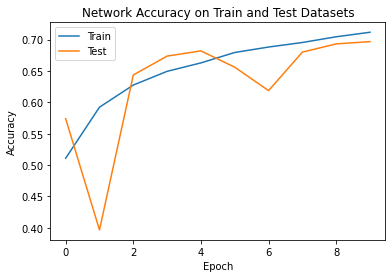

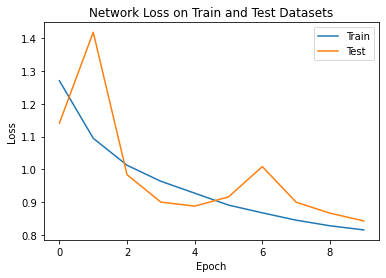

In [55]:
printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

### Checking Different Activation Functions

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.5407 - accuracy: 0.4493 - val_loss: 1.1391 - val_accuracy: 0.5680
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1999 - accuracy: 0.5497 - val_loss: 1.0127 - val_accuracy: 0.6200
Epoch 3/10
519/519 [==============================] - 21s 41ms/step - loss: 1.0734 - accuracy: 0.5999 - val_loss: 1.0045 - val_accuracy: 0.6043
Epoch 4/10
519/519 [==============================] - 21s 41ms/step - loss: 1.0105 - accuracy: 0.6246 - val_loss: 0.9294 - val_accuracy: 0.6626
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9587 - accuracy: 0.6473 - val_loss: 0.8950 - val_accuracy: 0.6909
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9254 - accuracy: 0.6639 - val_loss: 0.9874 - val_accuracy: 0.6241
Epoch 7/10
51

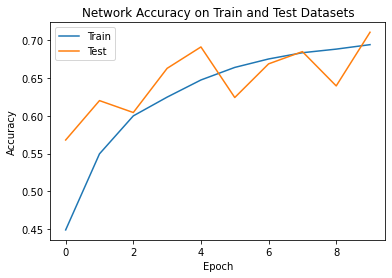

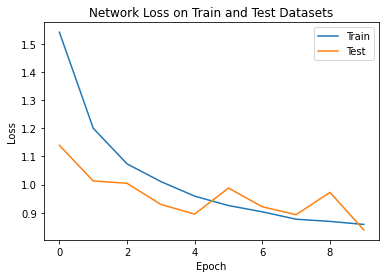

In [56]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "tanh",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2823 - accuracy: 0.5119 - val_loss: 1.1282 - val_accuracy: 0.5794
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0860 - accuracy: 0.6000 - val_loss: 1.0615 - val_accuracy: 0.6133
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0079 - accuracy: 0.6310 - val_loss: 1.0839 - val_accuracy: 0.5794
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9627 - accuracy: 0.6535 - val_loss: 0.9294 - val_accuracy: 0.6708
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9174 - accuracy: 0.6680 - val_loss: 0.9227 - val_accuracy: 0.6543
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8933 - accuracy: 0.6784 - val_loss: 0.8778 - val_accuracy: 0.6892
Epoch 7/10
51

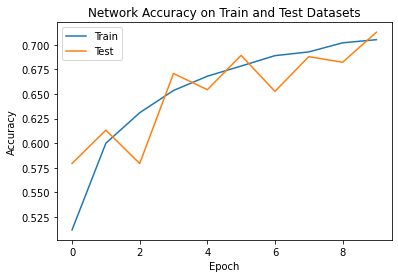

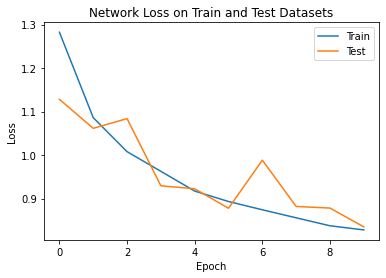

In [57]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.4041 - accuracy: 0.4469 - val_loss: 1.3777 - val_accuracy: 0.4434
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.3256 - accuracy: 0.4840 - val_loss: 1.3206 - val_accuracy: 0.4548
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2794 - accuracy: 0.5019 - val_loss: 1.2757 - val_accuracy: 0.4769
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2301 - accuracy: 0.5165 - val_loss: 1.2090 - val_accuracy: 0.5105
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1862 - accuracy: 0.5387 - val_loss: 1.1604 - val_accuracy: 0.5632
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1467 - accuracy: 0.5601 - val_loss: 1.1217 - val_accuracy: 0.5842
Epoch 7/10
51

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


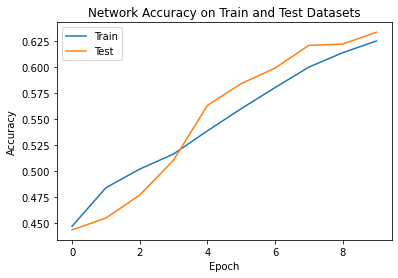

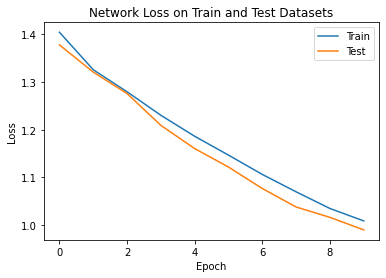

In [59]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "sigmoid",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Based on the results above LeakyRelu is the best one so I kept it for the next parts.

### Checking Optimizers

Now It's time for momentum in SGD here we've first put 0.5 then 0.9 for momentum then we've tried Adam

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 21s 41ms/step - loss: 1.2312 - accuracy: 0.5357 - val_loss: 1.2607 - val_accuracy: 0.4933
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0276 - accuracy: 0.6246 - val_loss: 0.9517 - val_accuracy: 0.6559
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9557 - accuracy: 0.6529 - val_loss: 0.9071 - val_accuracy: 0.6759
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9134 - accuracy: 0.6743 - val_loss: 0.8864 - val_accuracy: 0.6892
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8835 - accuracy: 0.6860 - val_loss: 0.8729 - val_accuracy: 0.6857
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8548 - accuracy: 0.6928 - val_loss: 0.9050 - val_accuracy: 0.6815
Epoch 7/10
51

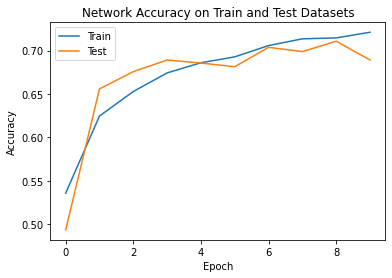

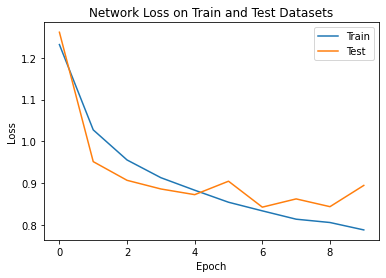

In [60]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD",
    desiredMomentum = 0.5
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 21s 40ms/step - loss: 1.3275 - accuracy: 0.5137 - val_loss: 1.0529 - val_accuracy: 0.6006
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0273 - accuracy: 0.6272 - val_loss: 1.0118 - val_accuracy: 0.6268
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9811 - accuracy: 0.6448 - val_loss: 0.9794 - val_accuracy: 0.6344
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9297 - accuracy: 0.6715 - val_loss: 0.8717 - val_accuracy: 0.6916
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9078 - accuracy: 0.6763 - val_loss: 0.9158 - val_accuracy: 0.6628
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.8867 - accuracy: 0.6865 - val_loss: 0.8866 - val_accuracy: 0.6943
Epoch 7/10
51

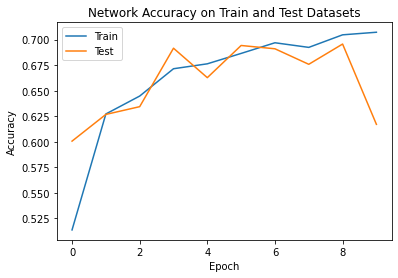

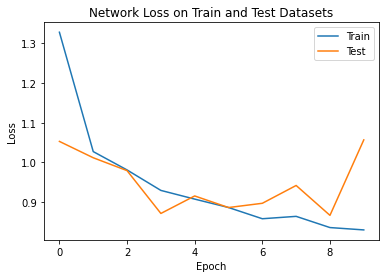

In [61]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.01,
    desiredOptimizer = "SGD",
    desiredMomentum = 0.9
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Momentum takes past gradients into account to smooth out the steps of gradient descent meaning that it accelerates gradient descent in the relevant direction and dampens oscillations. When momentum is 0 the formula below is used in SGD:

$ w = w - learningRate * g $

But when momentum is larger than 0 the formula below is used:

$ w = w + momentum * velocity - learningRate * g $

Exponential Smoothing is one of the simplest ways to add smoothing to your data. In our case, the Exponential Smoothing is called Momentum and it allows the optimizer to maintain the velocity and trajectory from previous time steps to affect the present. The weighting of previous time steps drops off exponentially so the most recent time step has the greatest impact.

Momentum optimizer is faster and better at optimizing the model in our problem. momentum is an easy and quick way to improve upon standard Stochastic Gradient Descent for optimizing Neural Network models.

As shown here increasing momentum rapidly doesn't always help the model work better. With a reasonably higher momentum the predictions become more stable but with really high momentums the model will became stable for just one class and will predict all the data in that class so this means that higher momentum is good but too high and it'll cause problems.

As the momentum increases, the speed of our movement towards the answer increases in such a way that it becomes difficult to reach the answer meaning that if for example momentum is too high we'll overshoot the answer each time and never reach it. It's better to move slower as we get closer to the answer. Higher momentum will make the model almost random and also in each propagation the weights will change more rapidly which isn't what we want.

With momentum we have to hit the sweet spot, not too high to overshoot not too low to be very slow, we have to tune it as much as possible. 

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/10
519/519 [==============================] - 22s 41ms/step - loss: 2.9453 - accuracy: 0.5007 - val_loss: 1.0542 - val_accuracy: 0.6280
Epoch 2/10
519/519 [==============================] - 21s 40ms/step - loss: 1.2077 - accuracy: 0.5796 - val_loss: 1.9270 - val_accuracy: 0.3274
Epoch 3/10
519/519 [==============================] - 21s 40ms/step - loss: 1.1557 - accuracy: 0.6030 - val_loss: 1.0106 - val_accuracy: 0.6217
Epoch 4/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0695 - accuracy: 0.6278 - val_loss: 0.9868 - val_accuracy: 0.6579
Epoch 5/10
519/519 [==============================] - 21s 40ms/step - loss: 1.0133 - accuracy: 0.6444 - val_loss: 1.3392 - val_accuracy: 0.5063
Epoch 6/10
519/519 [==============================] - 21s 40ms/step - loss: 0.9803 - accuracy: 0.6558 - val_loss: 0.8939 - val_accuracy: 0.7022
Epoch 7/10
51

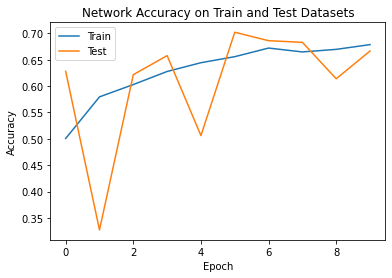

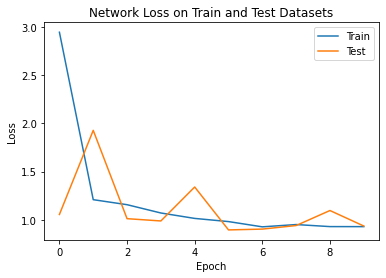

In [62]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.001,
    desiredOptimizer = "Adam"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 10
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Adam is an optimization algorithm that can be used instead of the SGD. The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter.

In multiple runs besides the one included here, Adam has performed better than SGD having higher accuracy on train and test set.

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/20
519/519 [==============================] - 21s 40ms/step - loss: 3.8110 - accuracy: 0.4872 - val_loss: 1.2380 - val_accuracy: 0.5020
Epoch 2/20
519/519 [==============================] - 21s 40ms/step - loss: 1.1744 - accuracy: 0.5864 - val_loss: 1.9797 - val_accuracy: 0.3884
Epoch 3/20
519/519 [==============================] - 21s 40ms/step - loss: 1.2395 - accuracy: 0.5864 - val_loss: 1.1327 - val_accuracy: 0.5874
Epoch 4/20
519/519 [==============================] - 21s 40ms/step - loss: 1.5110 - accuracy: 0.5942 - val_loss: 0.9866 - val_accuracy: 0.6549
Epoch 5/20
519/519 [==============================] - 21s 40ms/step - loss: 0.9716 - accuracy: 0.6591 - val_loss: 0.9772 - val_accuracy: 0.6608
Epoch 6/20
519/519 [==============================] - 21s 40ms/step - loss: 0.9616 - accuracy: 0.6627 - val_loss: 0.9915 - val_accuracy: 0.6435
Epoch 7/20
51

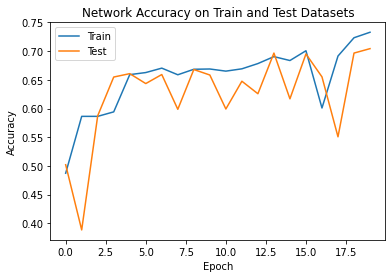

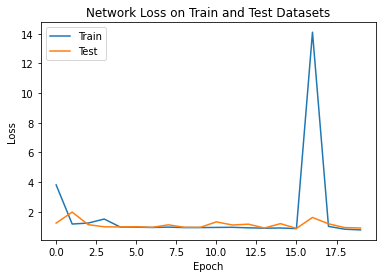

In [63]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.001,
    desiredOptimizer = "Adam"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 20
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Training a neural network involves optimizing a large set of parameters which are heavily interdependent. Because of this, it can take a lot of labelled training examples before the network even settles into an area of the solution space which is close to the optimal solution. The whole situation is made worse by the stochastic nature of batch gradient descent and the common practice of starting with a large learning rate and slowly lowering it. In short, the optimization algorithm is very data-hungry.

The sort of multidimensional data, neural nets require is expensive to label and takes up large amounts of storage space. Thus, even though you need to feed your network lots of data, the amount of samples available is generally much lower than the number of samples you need to reach a useful optimum. There may be enough information in these training samples, but the gradient descent algorithm takes time to extract it. You can make up for the limited number of samples by making multiple passes over the data. This will give the algorithm time to converge, without requiring an impractical amount of data. So in total batch gradient descent requires more iterations to converge than one pass over the data set will allow.

It's safe to say that in some special problems 1 epoch can be enough we will get good accuracy and everything but it's importent to note that gradient Descent is an iterative process so updating the weights with single pass or one epoch is not enough. One epoch leads to underfitting. As the number of epochs increases, more times the weights are changed in the neural network so the curve goes from underfitting to optimal to overfitting curve. So in total since updating the weights needs multiple number of passings(epochs) we'll have to train the model for multiple epochs.

After a lot of epochs the test accuracy starts to plummet but the train accuracy keeps on rising this is a clear sign of overfitting doing well on training set but doing horrible on test set. Even Loss value we can easily show overfitting, in the training set the loss keeps lowering but in test set loss value rises rapidly. So the best option is to train the model up until the very moment that overfitting starts by this approach we will prevent underfitting and also won't cause overfitting.

Increasing number of epochs by a lot will definitely result in overfitting so it won't be a good idea. To avoid the problem we have to hit the sweet spot meaning that we know really low number of epochs will result in underfitting and really high number of epochs will result in overfitting so the best possible way is to find where the underfitting stops and overfitting starts that is the best place since it neither has underfitting nor overfitting. That is the best possible epoch to achieve. But if we want to make our model better and overcome overfitting there all a lot of ways to do it and make the situation better like as we saw we can tune our hyperparameters, use different number of nodes in each hidden layer, use different number of hidden layers, study our data and know what approach to make based on the data, use other models and many more.

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2283 - accuracy: 0.4284 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 2/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2284 - accuracy: 0.4289 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 3/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2284 - accuracy: 0.4289 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 4/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2284 - accuracy: 0.4289 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 5/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2284 - accuracy: 0.4289 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 6/20
519/519 [==============================] - 21s 40ms/step - loss: 0.2284 - accuracy: 0.4289 - val_loss: 0.2334 - val_accuracy: 0.4164
Epoch 7/20
51

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


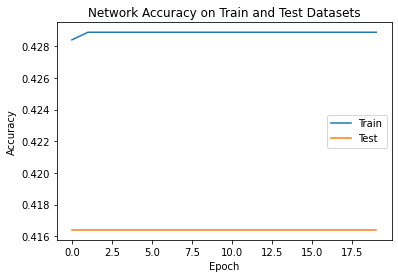

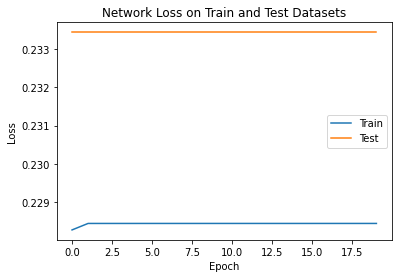

In [64]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "mean_squared_error",
    learningRate = 0.001,
    desiredOptimizer = "Adam"
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 20
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

As shown above the loss value while using MSE is constant meaning that the weights aren't updated. This will result in the network predicting everything as white class which is horrible Categorical Crossentropy is much better for our situation.

The Mean Squared Error is used as a default metric for evaluation of the performance of most regression algorithms meaning that MSE loss function is mostly used in regressions, where we are predicting age of a person, price of a house and many more. Here our problem is a classification problem with 5 classes White, Black, Asian, Indian and Others and it's certainly not a regression problem so MSE is not suitable here and Categorical Crossentropy is much more suitable.

Using MSE means that we assume that the underlying data has been generated from a normal distribution in reality, a dataset that can be classified into categories is not always from a normal distribution. Also if classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range (-inf, inf), while here classification models output probabilities in range (0,4). Also as said before MSE is a good choice for a Cost function when we are doing Linear Regression.

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/20
519/519 [==============================] - 22s 42ms/step - loss: 3.8225 - accuracy: 0.4942 - val_loss: 1.6230 - val_accuracy: 0.5749
Epoch 2/20
519/519 [==============================] - 22s 41ms/step - loss: 1.5871 - accuracy: 0.5848 - val_loss: 1.3994 - val_accuracy: 0.6535
Epoch 3/20
519/519 [==============================] - 21s 41ms/step - loss: 1.4721 - accuracy: 0.6092 - val_loss: 1.3970 - val_accuracy: 0.6240
Epoch 4/20
519/519 [==============================] - 21s 41ms/step - loss: 1.4540 - accuracy: 0.6058 - val_loss: 1.2729 - val_accuracy: 0.6467
Epoch 5/20
519/519 [==============================] - 21s 41ms/step - loss: 1.3249 - accuracy: 0.6304 - val_loss: 1.2353 - val_accuracy: 0.6373
Epoch 6/20
519/519 [==============================] - 22s 42ms/step - loss: 1.2392 - accuracy: 0.6405 - val_loss: 1.2152 - val_accuracy: 0.6508
Epoch 7/20
51

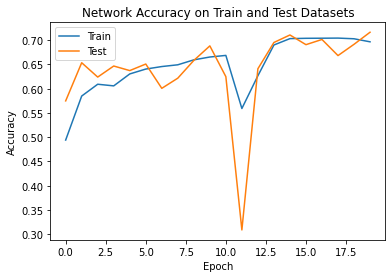

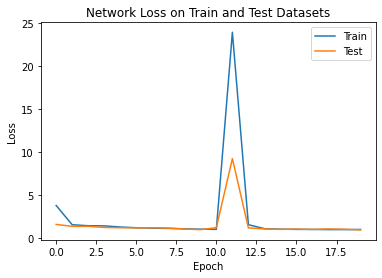

In [65]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.001,
    desiredOptimizer = "Adam",
    regularizer = regularizers.l2(l2 = 0.0001)
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 20
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/20
519/519 [==============================] - 22s 41ms/step - loss: 3.7694 - accuracy: 0.4630 - val_loss: 1.9791 - val_accuracy: 0.5424
Epoch 2/20
519/519 [==============================] - 21s 41ms/step - loss: 1.8102 - accuracy: 0.5457 - val_loss: 1.4599 - val_accuracy: 0.6244
Epoch 3/20
519/519 [==============================] - 21s 41ms/step - loss: 1.6088 - accuracy: 0.5814 - val_loss: 1.8935 - val_accuracy: 0.5491
Epoch 4/20
519/519 [==============================] - 21s 41ms/step - loss: 1.4534 - accuracy: 0.6073 - val_loss: 1.6045 - val_accuracy: 0.6051
Epoch 5/20
519/519 [==============================] - 21s 41ms/step - loss: 1.3700 - accuracy: 0.6156 - val_loss: 1.2620 - val_accuracy: 0.6406
Epoch 6/20
519/519 [==============================] - 21s 41ms/step - loss: 1.2977 - accuracy: 0.6257 - val_loss: 1.2182 - val_accuracy: 0.6348
Epoch 7/20
51

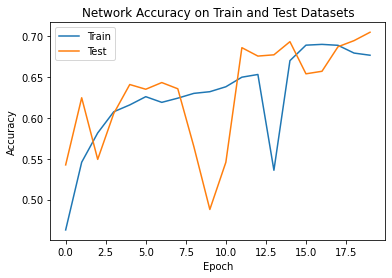

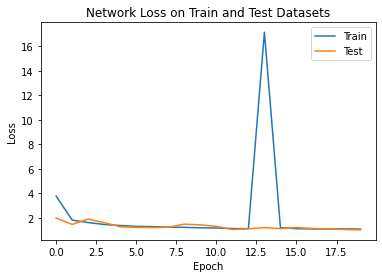

In [66]:
network , trainDataset , testDataset = splitDataConstructModel(
    dataFrame = dataFrame,
    numClasses = 5,
    scale = 1./255,
    validationSplit = 0.3,
    imageWidth = 100,
    batchSize = 32,
    numNodesFirstHiddenLayer = 2048,
    numNodeSecondHiddenLayer = 1024,
    hiddenLayerActivationFunc = "LeakyReLU",
    outputLayerActivationFunc = "softmax",
    lossFunc = "categorical_crossentropy",
    learningRate = 0.001,
    desiredOptimizer = "Adam",
    regularizer = regularizers.l2(l2 = 0.0001),
    hasDropout = True
)

history = network.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 20
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

Adding the regularization component will drive the values of the weight matrix down. This will effectively decorrelate the neural network.

Dropout involves going over all the layers in a neural network and setting probability of keeping a certain nodes or not meaning that the neural network cannot rely on any input node, since each have a random probability of being removed. Therefore, the neural network will be reluctant to give high weights to certain features, because they might disappear so the weights are spread across all features, making them smaller. This effectively shrinks the model and regularizes it.

L2 regularization works by adding a term to the error function used by the training algorithm. The additional term penalizes large weight values meaning that with L2 regularization you add a fraction of the sum of the squared weight values to the base error so on each training iteration, each weight is decayed toward zero by a small fraction of the weight's current value resulting in regularization and better results.

By using L2 regularization we improved the test accuracy and it's also noticeable that the model is not overfitting. Adding the dropout will make the results even better.

### Images with Correct or Wrong Predicitions 

In [67]:
trainPred = network.predict(trainDataset , batch_size = 32)
testPred = network.predict(testDataset , batch_size = 32)

trainPred = np.argmax(np.array(trainPred), axis = 1); trainActual = np.array(trainDataset.classes)
testPred = np.argmax(np.array(testPred), axis = 1); testActual = np.array(testDataset.classes)

highestIdx = 4

numCorrectsTrain = 10; numWrongTrain = 10; i = 0
correctIndicesTrain = []; wrongIndicesTrain = []
while(numCorrectsTrain > 0 or numWrongTrain > 0):
  if (trainPred[i] == trainActual[i] and numCorrectsTrain > 0):
    numCorrectsTrain -= 1
    correctIndicesTrain.append(i)
  elif (trainPred[i] != trainActual[i] and numWrongTrain > 0):
    numWrongTrain -= 1
    wrongIndicesTrain.append(i)
  
  i += 1

numCorrectsTest = 10; numWrongTest = 10; i = 0
correctIndicesTest = []; wrongIndicesTest = []
while(numCorrectsTest > 0 or numWrongTest > 0):
  if (testPred[i] == testActual[i] and numCorrectsTest > 0):
    numCorrectsTest -= 1
    correctIndicesTest.append(i)
  elif (testPred[i] != testActual[i] and numWrongTest > 0):
    numWrongTest -= 1
    wrongIndicesTest.append(i)
  
  i += 1

___________________________ Correct Predictions ___________________________


=============== Pred: Asian | Actual: Asian ===============

Image Path: /content/UTKFace/26_0_2_20170116180332055.jpg.chip.jpg



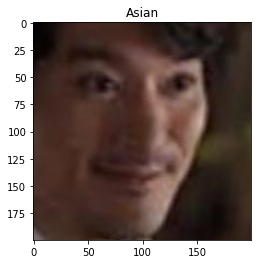


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/35_0_0_20170120221052421.jpg.chip.jpg



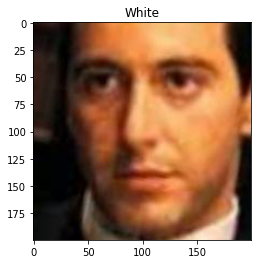


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/69_1_0_20170110131736764.jpg.chip.jpg



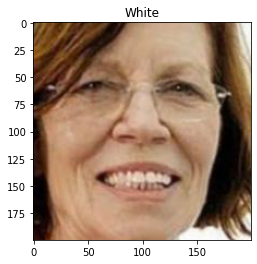


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/54_0_0_20170109012848473.jpg.chip.jpg



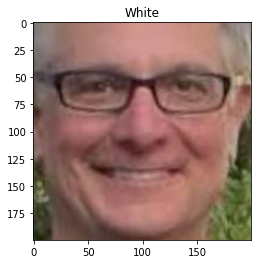


=============== Pred: Black | Actual: Black ===============

Image Path: /content/UTKFace/46_0_1_20170113141909603.jpg.chip.jpg



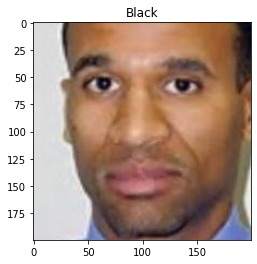


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/35_1_0_20170103181546899.jpg.chip.jpg



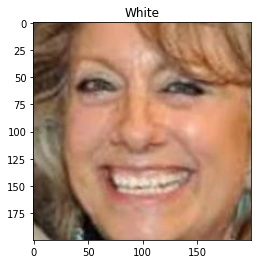


=============== Pred: Asian | Actual: Asian ===============

Image Path: /content/UTKFace/25_0_2_20170104021424381.jpg.chip.jpg



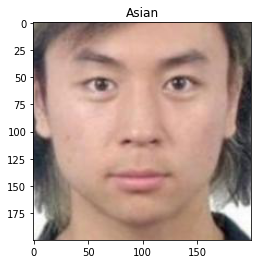


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/36_0_0_20170117175609824.jpg.chip.jpg



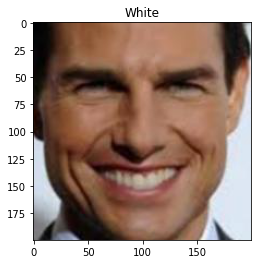


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/80_0_0_20170117175515838.jpg.chip.jpg



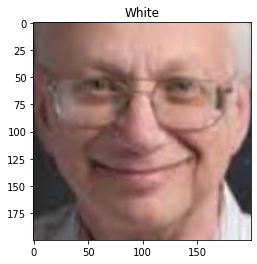


=============== Pred: Asian | Actual: Asian ===============

Image Path: /content/UTKFace/1_1_2_20161219222154119.jpg.chip.jpg



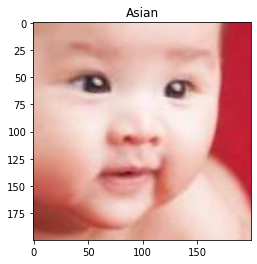



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/85_1_0_20170110183802977.jpg.chip.jpg



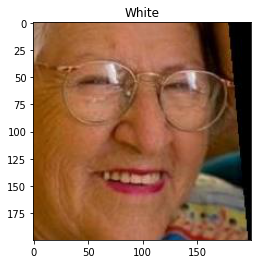


=============== Pred: Black | Actual: Black ===============

Image Path: /content/UTKFace/26_0_1_20170113151548832.jpg.chip.jpg



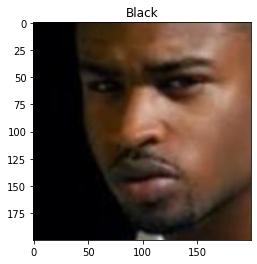


=============== Pred: Black | Actual: Black ===============

Image Path: /content/UTKFace/26_1_1_20170116233613793.jpg.chip.jpg



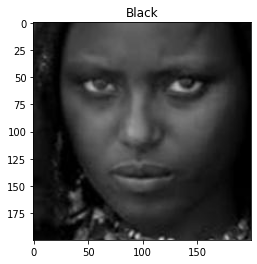


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/28_0_0_20170117191934140.jpg.chip.jpg



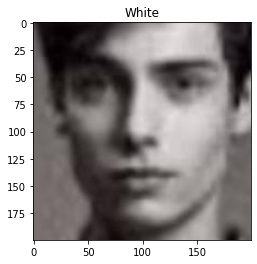


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/21_1_0_20170117193748045.jpg.chip.jpg



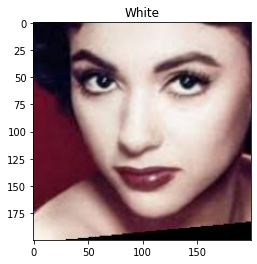


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/46_0_0_20170104200811706.jpg.chip.jpg



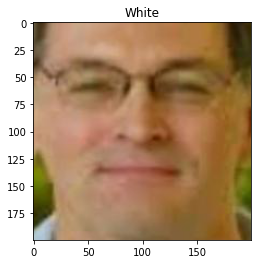


=============== Pred: Black | Actual: Black ===============

Image Path: /content/UTKFace/61_0_1_20170113175551340.jpg.chip.jpg



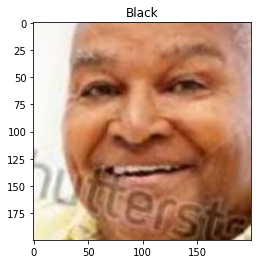


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/60_0_0_20170119204301455.jpg.chip.jpg



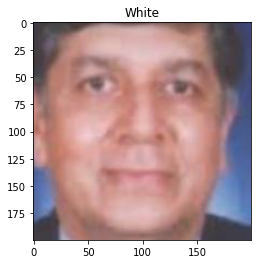


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/72_0_0_20170111181750515.jpg.chip.jpg



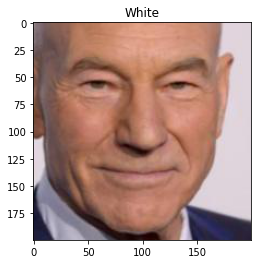


=============== Pred: White | Actual: White ===============

Image Path: /content/UTKFace/29_1_0_20170117202746975.jpg.chip.jpg



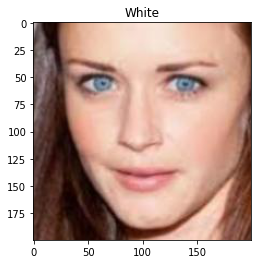

In [68]:
print("___________________________ Correct Predictions ___________________________\n")
for correctTrainIdx in correctIndicesTrain:
  targetImage = plt.imread(trainDataset.filenames[correctTrainIdx])

  print("\n=============== Pred: " + class_labels[highestIdx - trainPred[correctTrainIdx]] + " | Actual: " + class_labels[highestIdx - trainActual[correctTrainIdx]] + " ===============\n")

  print("Image Path: " + trainDataset.filenames[correctTrainIdx] + "\n")

  plt.figure()
  plt.imshow(targetImage)
  plt.title(class_labels[highestIdx - trainActual[correctTrainIdx]])
  plt.show()

print("\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

for correctTestIdx in correctIndicesTest:
  targetImage = plt.imread(testDataset.filenames[correctTestIdx])

  print("\n=============== Pred: " + class_labels[highestIdx - testPred[correctTestIdx]] + " | Actual: " + class_labels[highestIdx - testActual[correctTestIdx]] + " ===============\n")

  print("Image Path: " + testDataset.filenames[correctTestIdx] + "\n")

  plt.figure()
  plt.imshow(targetImage)
  plt.title(class_labels[highestIdx - testActual[correctTestIdx]])
  plt.show()

___________________________ Wrong Predictions ___________________________


=============== Pred: Asian | Actual: Indian ===============

Image Path: /content/UTKFace/1_1_3_20161219225035448.jpg.chip.jpg



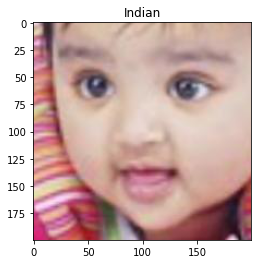


=============== Pred: Asian | Actual: Indian ===============

Image Path: /content/UTKFace/1_1_3_20161219224553880.jpg.chip.jpg



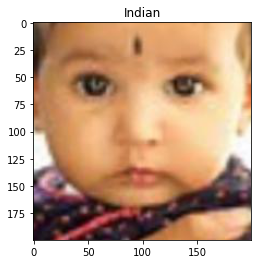


=============== Pred: Asian | Actual: White ===============

Image Path: /content/UTKFace/16_0_0_20170104012325066.jpg.chip.jpg



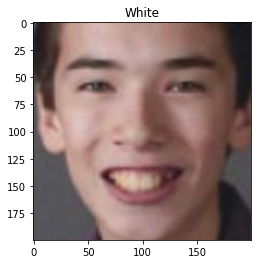


=============== Pred: White | Actual: Asian ===============

Image Path: /content/UTKFace/85_1_2_20170110182342530.jpg.chip.jpg



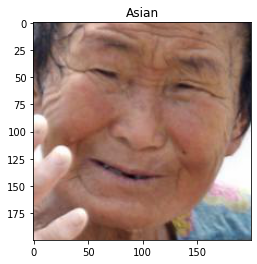


=============== Pred: Asian | Actual: Others ===============

Image Path: /content/UTKFace/2_1_4_20161221195057952.jpg.chip.jpg



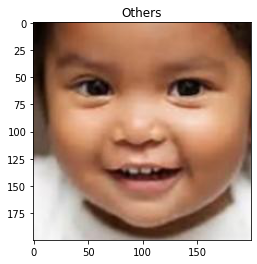


=============== Pred: White | Actual: Others ===============

Image Path: /content/UTKFace/35_0_4_20170117195110413.jpg.chip.jpg



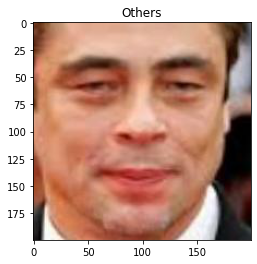


=============== Pred: Indian | Actual: Asian ===============

Image Path: /content/UTKFace/30_1_2_20170116163322535.jpg.chip.jpg



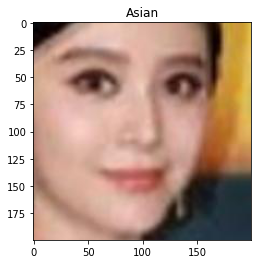


=============== Pred: Asian | Actual: White ===============

Image Path: /content/UTKFace/58_0_0_20170117191942332.jpg.chip.jpg



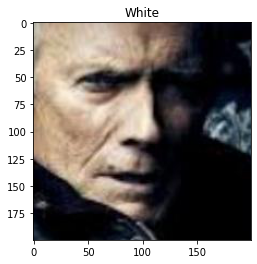


=============== Pred: White | Actual: Asian ===============

Image Path: /content/UTKFace/26_1_2_20170116184512597.jpg.chip.jpg



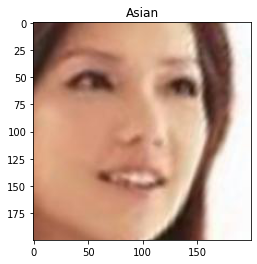


=============== Pred: White | Actual: Black ===============

Image Path: /content/UTKFace/60_0_1_20170116233417966.jpg.chip.jpg



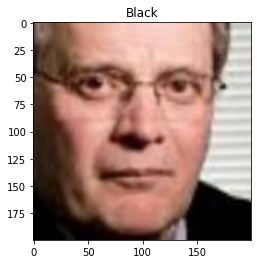


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


=============== Pred: Black | Actual: White ===============

Image Path: /content/UTKFace/26_0_0_20170104170627658.jpg.chip.jpg



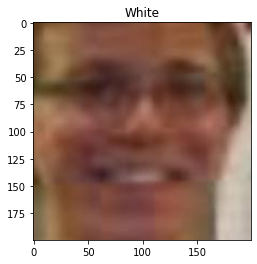


=============== Pred: Black | Actual: White ===============

Image Path: /content/UTKFace/65_1_0_20170110131349129.jpg.chip.jpg



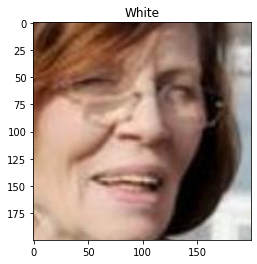


=============== Pred: White | Actual: Indian ===============

Image Path: /content/UTKFace/45_0_3_20170119194520650.jpg.chip.jpg



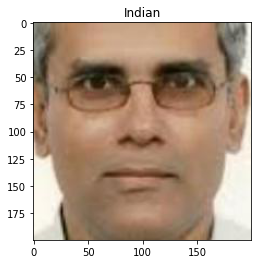


=============== Pred: Black | Actual: White ===============

Image Path: /content/UTKFace/37_0_0_20170119202407877.jpg.chip.jpg



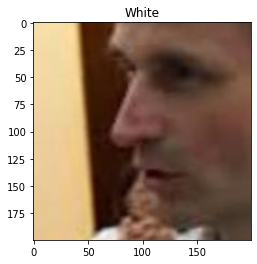


=============== Pred: Black | Actual: White ===============

Image Path: /content/UTKFace/50_0_0_20170113210604690.jpg.chip.jpg



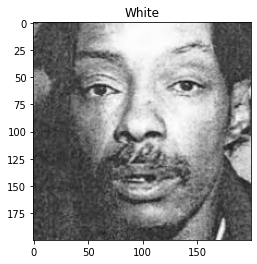


=============== Pred: White | Actual: Black ===============

Image Path: /content/UTKFace/24_0_1_20170116193001978.jpg.chip.jpg



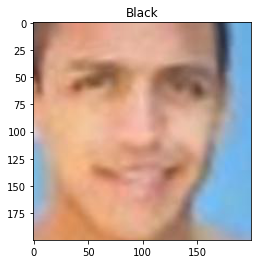


=============== Pred: White | Actual: Indian ===============

Image Path: /content/UTKFace/18_1_3_20170117135716054.jpg.chip.jpg



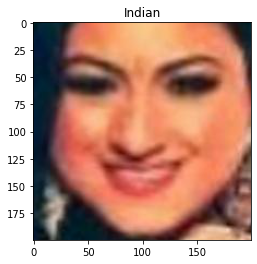


=============== Pred: Asian | Actual: Others ===============

Image Path: /content/UTKFace/1_0_4_20161221195955560.jpg.chip.jpg



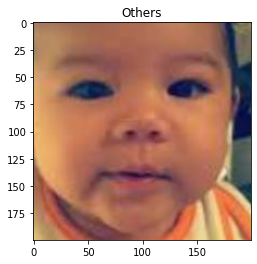


=============== Pred: Black | Actual: Others ===============

Image Path: /content/UTKFace/50_0_4_20170117203102320.jpg.chip.jpg



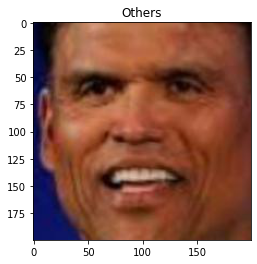


=============== Pred: Asian | Actual: Others ===============

Image Path: /content/UTKFace/26_1_4_20170117174316560.jpg.chip.jpg



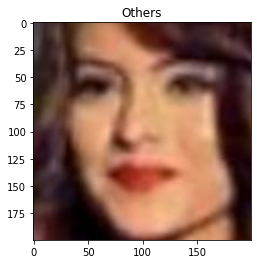

In [69]:
print("___________________________ Wrong Predictions ___________________________\n")
for wrongTrainIdx in wrongIndicesTrain:
  targetImage = plt.imread(trainDataset.filenames[wrongTrainIdx])

  print("\n=============== Pred: " + class_labels[highestIdx - trainPred[wrongTrainIdx]] + " | Actual: " + class_labels[highestIdx - trainActual[wrongTrainIdx]] + " ===============\n")

  print("Image Path: " + trainDataset.filenames[wrongTrainIdx] + "\n")

  plt.figure()
  plt.imshow(targetImage)
  plt.title(class_labels[highestIdx - trainActual[wrongTrainIdx]])
  plt.show()

print("\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++TEST+++++")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

for wrongTestIdx in wrongIndicesTest:
  targetImage = plt.imread(testDataset.filenames[wrongTestIdx])

  print("\n=============== Pred: " + class_labels[highestIdx - testPred[wrongTestIdx]] + " | Actual: " + class_labels[highestIdx - testActual[wrongTestIdx]] + " ===============\n")

  print("Image Path: " + testDataset.filenames[wrongTestIdx] + "\n")

  plt.figure()
  plt.imshow(targetImage)
  plt.title(class_labels[highestIdx - testActual[wrongTestIdx]])
  plt.show()

The values predicted by the network follow the pattern below and it's the reversed of what we want so we have to reverse each time. The problem is with flow_from_dataframe which for some reason doesn't accept classes attribute it works fine with flow_from_directory but with this method given any value for class attribute the resulting class_indices will be as below.

In [70]:
trainDataset.class_indices

{'[0. 0. 0. 0. 1.]': 0,
 '[0. 0. 0. 1. 0.]': 1,
 '[0. 0. 1. 0. 0.]': 2,
 '[0. 1. 0. 0. 0.]': 3,
 '[1. 0. 0. 0. 0.]': 4}

In [71]:
testDataset.class_indices

{'[0. 0. 0. 0. 1.]': 0,
 '[0. 0. 0. 1. 0.]': 1,
 '[0. 0. 1. 0. 0.]': 2,
 '[0. 1. 0. 0. 0.]': 3,
 '[1. 0. 0. 0. 0.]': 4}

### Encoder

Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.
Epoch 1/20
519/519 [==============================] - 22s 42ms/step - loss: 2.5780 - accuracy: 0.3756 - val_loss: 1.8312 - val_accuracy: 0.4181
Epoch 2/20
519/519 [==============================] - 21s 41ms/step - loss: 1.7978 - accuracy: 0.4024 - val_loss: 1.6120 - val_accuracy: 0.4783
Epoch 3/20
519/519 [==============================] - 21s 41ms/step - loss: 1.6602 - accuracy: 0.4199 - val_loss: 1.5256 - val_accuracy: 0.4833
Epoch 4/20
519/519 [==============================] - 21s 41ms/step - loss: 1.5495 - accuracy: 0.4385 - val_loss: 1.4944 - val_accuracy: 0.4897
Epoch 5/20
519/519 [==============================] - 21s 41ms/step - loss: 1.4754 - accuracy: 0.4531 - val_loss: 1.4079 - val_accuracy: 0.5506
Epoch 6/20
519/519 [==============================] - 21s 41ms/step - loss: 1.4061 - accuracy: 0.4879 - val_loss: 1.3552 - val_accuracy: 0.5006
Epoch 7/20
51

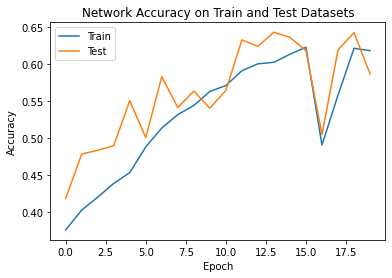

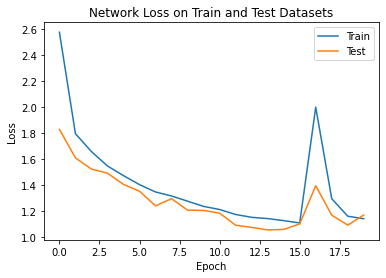

In [72]:
dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1./255 ,
    validation_split = 0.3
)

trainDataset = dataGenerator.flow_from_dataframe(
    dataframe = dataFrame,
    x_col = "image",
    y_col = "race",
    target_size = (100 , 100),
    color_mode = "grayscale",
    batch_size = 32,
    subset = "training",
    class_mode = "categorical",
    shuffle = False
)

testDataset = dataGenerator.flow_from_dataframe(
    dataframe = dataFrame,
    x_col = "image",
    y_col = "race",
    target_size = (100 , 100),
    color_mode = "grayscale",
    batch_size = 32,
    subset = "validation",
    class_mode = "categorical",
    shuffle = False
)

input = layers.Input(shape = (100 , 100 , 1))
output = layers.Flatten()(input)
output = layers.Dense(2048 , activation = "LeakyReLU" , kernel_regularizer = regularizers.l2(l2 = 0.0001) , bias_regularizer = regularizers.l2(l2 = 0.0001))(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(1024 , activation = "LeakyReLU" , kernel_regularizer = regularizers.l2(l2 = 0.0001) , bias_regularizer = regularizers.l2(l2 = 0.0001))(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(2 , activation = "LeakyReLU" , kernel_regularizer = regularizers.l2(l2 = 0.0001) , bias_regularizer = regularizers.l2(l2 = 0.0001))(output)
encoded = layers.Dropout(0.1)(output)
decoded = layers.Dense(5 , activation = "softmax" , kernel_regularizer = regularizers.l2(l2 = 0.0001) , bias_regularizer = regularizers.l2(l2 = 0.0001))(encoded)

autoEncoder = models.Model(inputs = input , outputs = decoded)

encoderModel = models.Model(inputs = input , outputs = encoded)

encodedInput = layers.Input(shape = (2 ,) )
decoderModel = models.Model(inputs = encodedInput , outputs = autoEncoder.layers[-1](encodedInput) )

autoEncoder.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

history = autoEncoder.fit(
    trainDataset,
    validation_data = testDataset,
    epochs = 20
)

printPerformanceValuesAndFigures(
    network = network,
    trainDataset = trainDataset,
    testDataset = testDataset,
    fitHistory = history,
    batchSize = 32
)

In [73]:
encodedTrainImages = encoderModel.predict(trainDataset , batch_size = 32)
decodedTrainImages = decoderModel.predict(encodedTrainImages , batch_size = 32)

encodedTestImages = encoderModel.predict(testDataset , batch_size = 32)
decodedTestImages = decoderModel.predict(encodedTestImages , batch_size = 32)

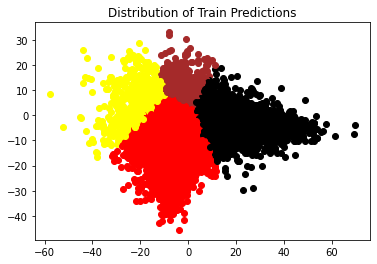

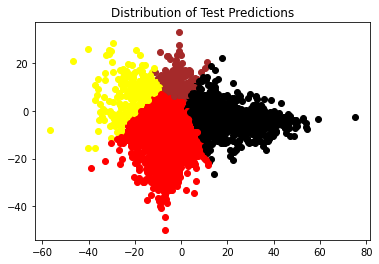

In [79]:
# red => White | black => Black | yellow => Asian | brown => Indian | blue => Others
colors = ["red" , "black" , "yellow" , "brown" , "blue"][::-1]

encodedTrainPreds = np.argmax(np.array(decodedTrainImages), axis = 1)
encodedTestPreds = np.argmax(np.array(decodedTestImages), axis = 1)

for i in range(len(encodedTrainImages)):
  plt.scatter(encodedTrainImages[i][0] , encodedTrainImages[i][1] , color = colors[encodedTrainPreds[i]] )
plt.title("Distribution of Train Predictions")
plt.show()

for i in range(len(encodedTestImages)):
  plt.scatter(encodedTestImages[i][0] , encodedTestImages[i][1] , color = colors[encodedTestPreds[i]] )
plt.title("Distribution of Test Predictions")
plt.show()

In [84]:
print(trainDataset.class_indices)
print(testDataset.class_indices)

{'[0. 0. 0. 0. 1.]': 0, '[0. 0. 0. 1. 0.]': 1, '[0. 0. 1. 0. 0.]': 2, '[0. 1. 0. 0. 0.]': 3, '[1. 0. 0. 0. 0.]': 4}
{'[0. 0. 0. 0. 1.]': 0, '[0. 0. 0. 1. 0.]': 1, '[0. 0. 1. 0. 0.]': 2, '[0. 1. 0. 0. 0.]': 3, '[1. 0. 0. 0. 0.]': 4}


Based on the results from the model performance and the plots above we can conclude that for white, Black and Asian the model is predicting pretty good. As shown in the plots you can easily detect the border of each of these classes. It's also noticable that in these classes the model performs well both on the train and test set so no case of overfitting or underfitting is causing problem. For Indian class the model predicts reasonably but not as good as the previously mentioned classes. There are some parts that Black and Indian classes collide and the border kinda messes up but in total the predictions are quite good but not completely perfect. For Others class the model is performing badly and the predictions are messed up here. Also in the plots there were no predictions for this class, which is bad but also by taking a look at the cell above the values corresponding to Others class aren't that good either so the model is predicting pretty bad for Others class.

By chacking some of the pictures in Others class I came across some pictures that could belong to other classes as well and I felt like the Others class is broad and thought maybe that's one of the reasons the model messes up Others class, but also it's safe to say that the model itself including the architecture and hyperparameters of it play an importent role in this phenomena.